In [1]:
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import rasterio as rio
from rasterio.enums import Resampling
import json
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from PIL import ImageColor
import skimage as ski
from skimage.exposure import rescale_intensity
import scipy
from rasterio.features import shapes
from dotenv import load_dotenv

load_dotenv()

True

## Data Preparation 

This is where you supposed to put your file location so that it can be loaded to the script

In [2]:

lc_dir = '../data/lcb.json'
sample_dir = "../data/lc_bangore.geojson"
sentinel_2 = "../data/Sentinel2_Composite.tif"

In [3]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

palette  values       label  values_normalize
0  #e34a33    1000       Urban                 1
1  #ffc107    2000   Soil bare                 2
2  #1e88e5    3000       Water                 3
3  #004d40    4000  Vegetation                 4

(33, 5)


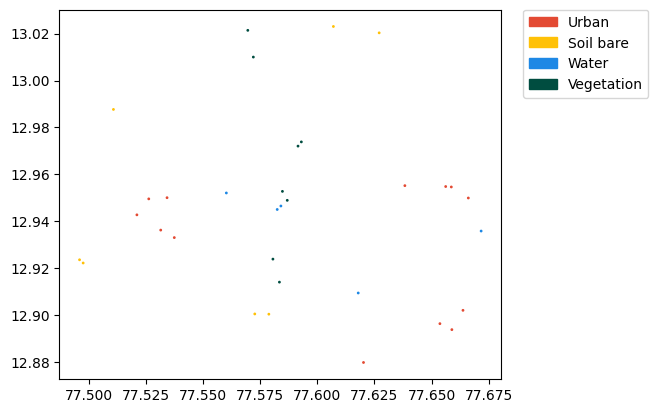

In [4]:
sample = gpd.read_file(sample_dir)
sample["value"] = sample["lc"].map(dict_values)
sample["label"] = sample["value"].map(dict_label)

# Plot sample
sample.plot(column="value", cmap=cmap, markersize=1)
plt.legend(**legend)

# Sample with extract
sample_extract = sample.copy()
coords = [
    (x, y) for x, y in zip(sample_extract["geometry"].x, sample_extract["geometry"].y)
]
print(sample_extract.shape)

### Showing and Extract Landsat Raster Values ###
This part is where we can see how the Landsat image look alike.

You should adjust which band to use and the scale min max value to show your data

This part also show you how we sample the value of pixel in the Landsat with our sample

In [6]:
# Load landsat image
sentinel_2 = rio.open(sentinel_2)
sentinel_2_image = sentinel_2.read() /1e4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011392405063291136..2.9270886075949365].


lc  id                   geometry  value  label       B1       B2  \
0  1000   0  POINT (77.65618 12.95477)      1  Urban  0.10580  0.08650   
1  1000   1  POINT (77.65865 12.95459)      1  Urban  0.10705  0.12100   
2  1000   2  POINT (77.63831 12.95515)      1  Urban  0.09930  0.11340   
3  1000   3   POINT (77.6661 12.94988)      1  Urban  0.07135  0.10135   
4  1000   4  POINT (77.66376 12.90195)      1  Urban  0.10750  0.16280   

        B3      B4       B5       B6       B7       B8      B8A       B9  \
0  0.10075  0.1152  0.17555  0.18410  0.18765  0.16690  0.19710  0.21235   
1  0.15040  0.1813  0.18465  0.20065  0.20025  0.19040  0.20955  0.22950   
2  0.13320  0.1594  0.18420  0.21810  0.23485  0.24235  0.24800  0.23235   
3  0.10860  0.1173  0.13000  0.13095  0.13485  0.12550  0.13990  0.18930   
4  0.19270  0.2166  0.23825  0.24035  0.24780  0.23295  0.25550  0.21105   

       B11      B12  
0  0.21070  0.18670  
1  0.25065  0.22605  
2  0.25190  0.21025  
3  0.17745  0.16755  
4  0.26930  0.23885

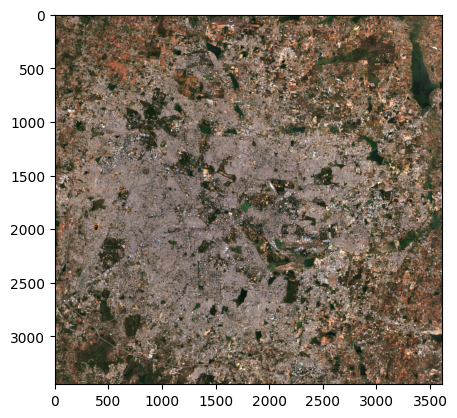

In [9]:
# False color composite
out_range = (0, 3)
red = rescale_intensity(sentinel_2_image [3], in_range=(0.01, 0.8), out_range=out_range)
green = rescale_intensity(sentinel_2_image [2], in_range=(0.01, 0.8), out_range=out_range)
blue = rescale_intensity(sentinel_2_image [1], in_range=(0.01, 0.7), out_range=out_range)
arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

# Extract raster value
sentinel_2_extract = np.stack(
    [x for x in sentinel_2.sample(coords)]
) / 1e4
sample_extract[["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8","B8A","B9", "B11", "B12"]] = sentinel_2_extract
sample_extract.head()


In [10]:
# Split sample to train and test
seeds = 2
train, test = train_test_split(sample_extract, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 23
Test size: 10


In [11]:
# Make random forest model
predictors = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8","B8A","B9", "B11", "B12"]
model = RandomForestClassifier(100)
model.fit(
    train[predictors],
    train["value"]
)

RandomForestClassifier()

              precision    recall  f1-score   support

           1       1.00      0.75      0.86         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2

    accuracy                           0.90        10
   macro avg       0.92      0.94      0.91        10
weighted avg       0.93      0.90      0.90        10



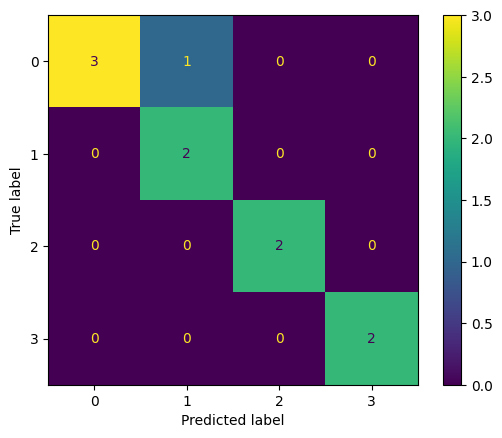

In [19]:
# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['value'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['value'], test_apply)
print(report)

In [22]:
# Load image
combine_image = sentinel_2_image
image_transpose = combine_image.T
transpose_shape = image_transpose.shape
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8","B8A","B9", "B11", "B12"],
)
table_image

B1       B2       B3       B4       B5       B6       B7  \
0         0.0628  0.05165  0.08410  0.11905  0.17505  0.25615  0.28450   
1         0.0628  0.08085  0.12060  0.17275  0.22880  0.27230  0.30490   
2         0.0628  0.10140  0.14240  0.21075  0.22880  0.27230  0.30490   
3         0.0628  0.10590  0.14770  0.21400  0.25790  0.28835  0.31515   
4         0.0628  0.11140  0.15260  0.22040  0.25790  0.28835  0.31515   
...          ...      ...      ...      ...      ...      ...      ...   
12440379  0.0738  0.05535  0.07705  0.07540  0.11570  0.17275  0.20025   
12440380  0.0738  0.05500  0.07650  0.07475  0.11570  0.17275  0.20025   
12440381  0.0591  0.05560  0.07305  0.07470  0.11280  0.15445  0.17365   
12440382  0.0591  0.05520  0.07205  0.07535  0.11280  0.15445  0.17365   
12440383  0.0591  0.05690  0.07650  0.07780  0.11435  0.15755  0.17840   

               B8      B8A       B9      B11      B12  
0         0.29485  0.30995  0.31390  0.34165  0.24565  
1         0.31620  0.33175  0.31390  0.41555  0.31275  
2         0.31735  0.33175  0.31390  0.41555  0.31275  
3         0.31940  0.34685  0.31390  0.45395  0.33955  
4         0.32740  0.34685  0.31390  0.45395  0.33955  
...           ...      ...      ...      ...      ...  
12440379  0.20270  0.22705  0.24405  0.23620  0.15885  
12440380  0.18520  0.22705  0.24405  0.23620  0.15885  
12440381  0.18100  0.20080  0.21960  0.23615  0.16385  
12440382  0.18130  0.20080  0.21960  0.23615  0.16385  
12440383  0.18990  0.20435  0.21960  0.24330  0.16155  

[12440384 rows x 12 columns]

In [23]:
prediction = model.predict(table_image[predictors])
prediction

array([2, 2, 2, ..., 1, 1, 1])

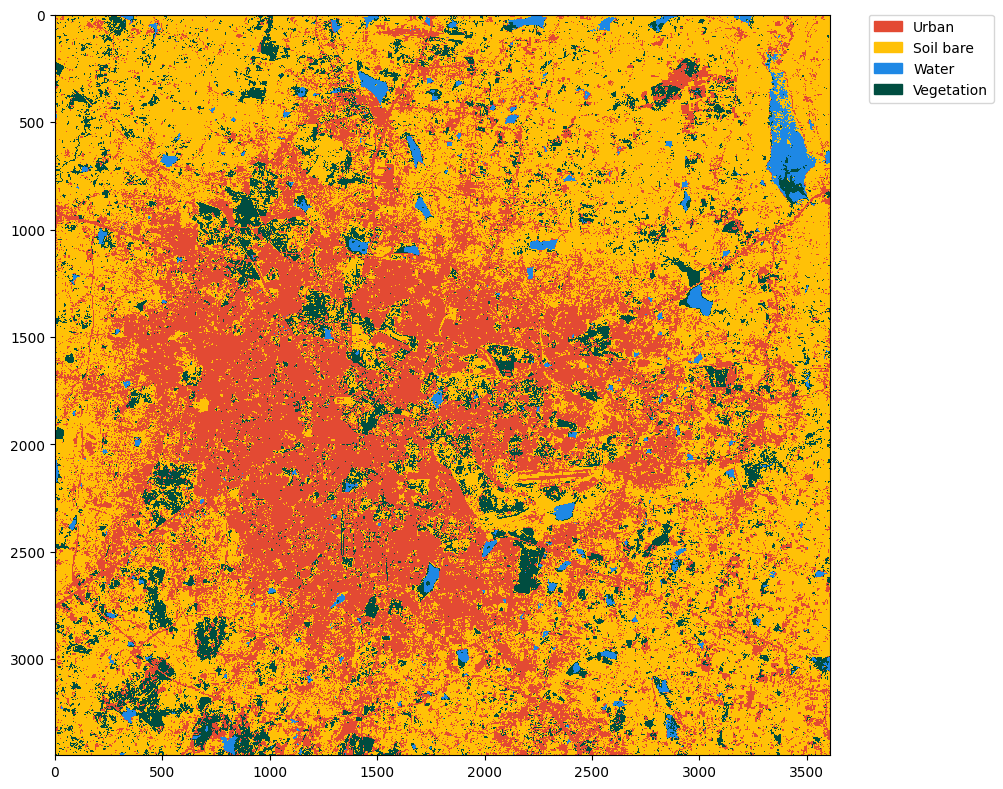

In [32]:
# Prediction to image again
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

# Show to plot
plt.figure(figsize=(10, 10))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

In [33]:
# Save image to geotiff
output = rio.open(
    "../data/LULC.tif",
    "w",
    "COG",
    count=1,
    width=prediction_image.shape[1],
    height=prediction_image.shape[0],
    crs=sentinel_2.crs,
    transform=sentinel_2.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(prediction_image, 1)
output.close()

Warning 6: driver COG does not support creation option TILED


## Image Segmentation ##

Sometime the result of land cover classification too many salt and pepper effect

This section will show you how to create a segmented land cover where this affect is dismissed

We will generate a segmentation using SLIC algorithms then used it to calculate zonal statistics per segment in the land cover data we have generated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011392405063291136..2.9270886075949365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


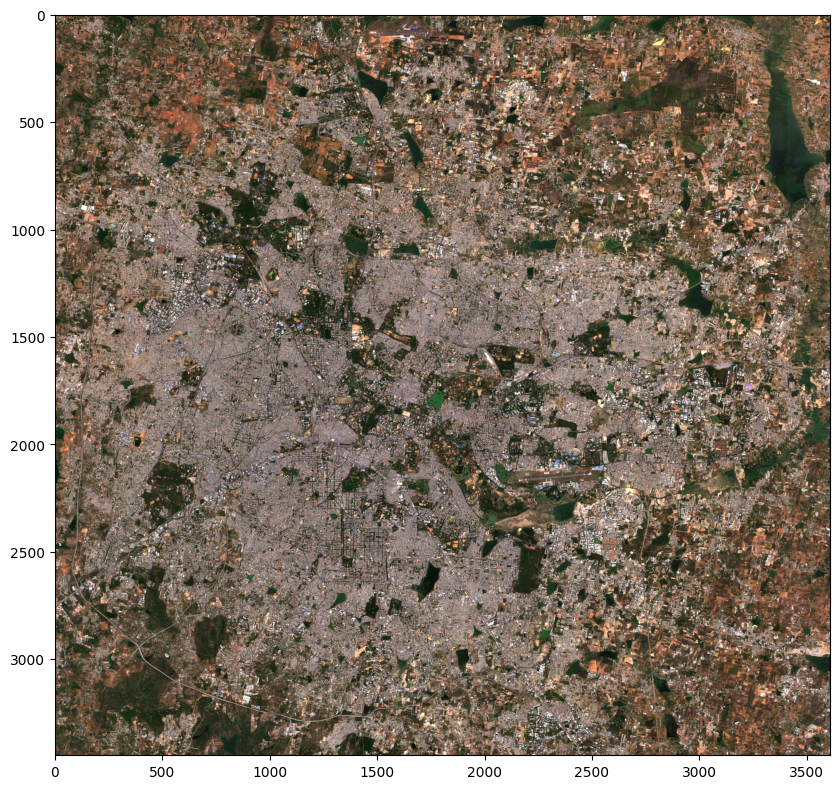

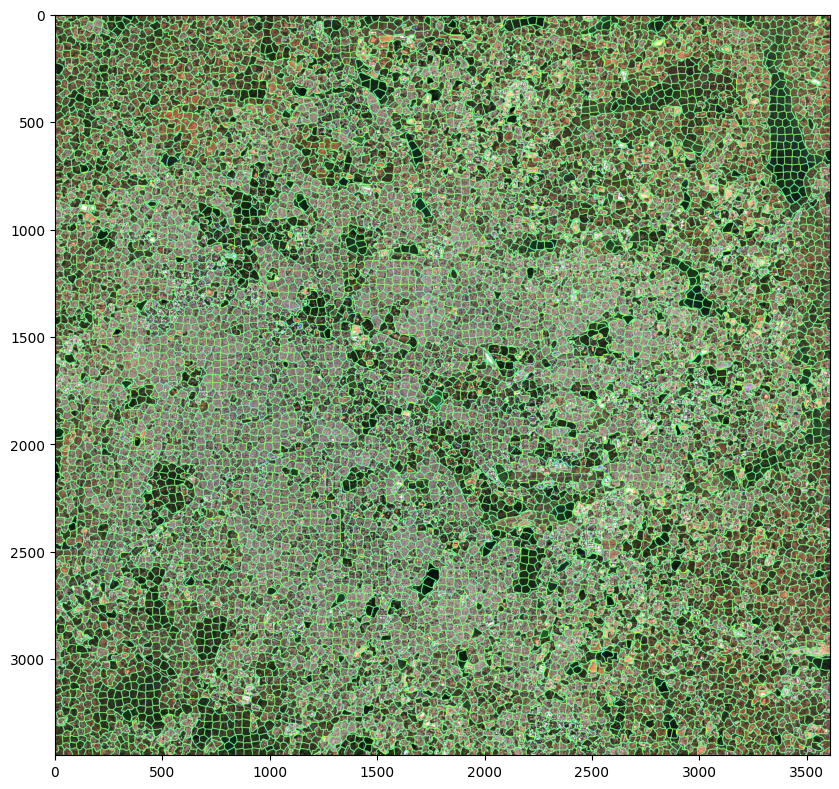

In [35]:
# Image segmentation

# Do uniform filter to composite image
seed_image = composite
plt.figure(figsize=(10, 10))
plt.imshow(seed_image)

# Segmentation
segment = ski.segmentation.slic(
    seed_image, n_segments=10000, compactness=5, sigma=5
)
plt.figure(figsize=(10, 10))
plt.imshow(ski.segmentation.mark_boundaries(composite, segment, outline_color=(0, 255, 255)))

### Calculating Mode of Land Cover Per Segment ###

After the segment is created, each segment will be used to calculate the mode of land cover that overlayed it

Then show the result just like the previous non segmented one

In [36]:
# Get the mode of each segment
segment_unique = np.unique(segment)
lc_segment = segment.copy()
for x in segment_unique:
    lc_segment[segment == x] = scipy.stats.mode(prediction_image[segment == x]).mode
lc_segment

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

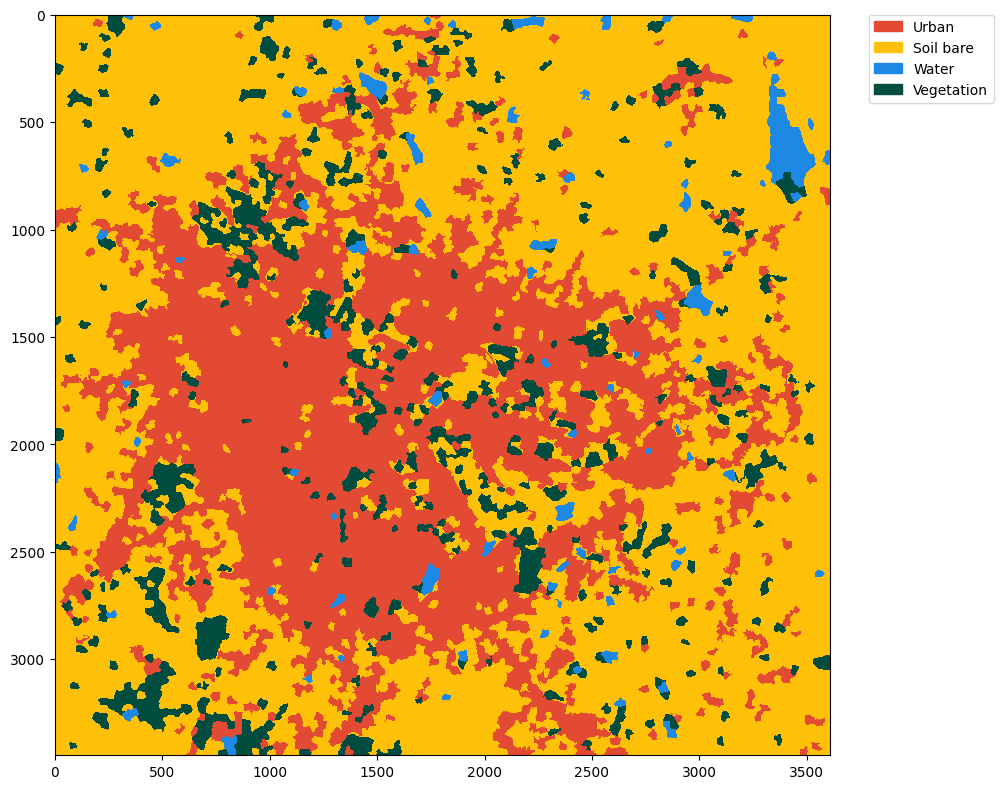

In [37]:
# Show to plot the segmented LC
plt.figure(figsize=(10, 10))
plt.imshow(lc_segment, cmap=cmap, interpolation="nearest")
plt.legend(**legend)

In [39]:
# Save image to geotiff
output = rio.open(
    "../data/LULC_Segment.tif",
    "w",
    "COG",
    count=1,
    width=lc_segment.shape[1],
    height=lc_segment.shape[0],
    crs=sentinel_2.crs,
    transform=sentinel_2.transform,
    dtype="uint8",
    nodata=0,
    compress="lzw",
    resampling="mode",
    tiled=True,
)
output.write_colormap(1, dict_palette)
output.write(lc_segment, 1)
output.close()

Warning 6: driver COG does not support creation option TILED


/Users/clementkm/Documents/DEVELOPEMENT/lc-classification-python/env/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


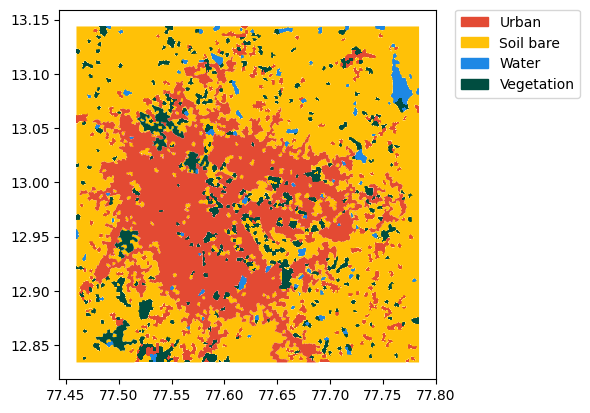

In [40]:
# Convert raster to shapefile
lc_vector = [{ "type": "Feature", "properties": { "lc": x[1] }, "geometry": x[0] } for x in shapes(lc_segment.astype('uint8'), transform=sentinel_2.transform)]
lc_vector = json.dumps({
    "type": "FeatureCollection",
	"properties": {},
	"features": lc_vector
})

# Read as geodataframe
lc_df = gpd.read_file(lc_vector, driver='GeoJSON')

# Plot it
lc_df.plot(column="lc", cmap=cmap)
plt.legend(**legend)

In [45]:
# Add another column such as palette and label
lc_df["palette"] = lc_df["lc"].map(dict_palette_hex)
lc_df["label"] = lc_df["lc"].map(dict_label)

# Save the file
lc_df.to_file("../data/LULC_Shapefile.shp")